In [1]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [ ]:
# 整数の集合を定義します。
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)



In [4]:
# 上で求めたQ_{ii}, Q_{ij}を{(i, j): Q_{ij}}のような辞書型で定義します。
Q = {}
for i in range(N):
    Q[i, i] = 4 * C[i] * (C[i] - sum(C))
    for j in range(i + 1, N):
        Q[i, j] = 8 * C[i] * C[j]

In [6]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

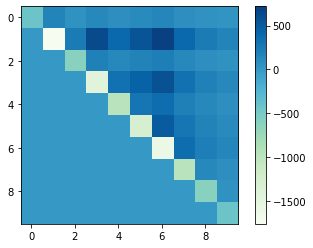

In [7]:
show_qubo(Q)

In [8]:
# h_iとJ_ijを定義します。
h = {}
J = {}
for i in range(N):
    h[i] = 0
    for j in range(i + 1, N):
        J[i, j] = 2 * C[i] * C[j]



In [10]:
import dimod

In [24]:
# イジングモデルからQUBOへの変換を行います。
model = dimod.BinaryQuadraticModel(h, J, 0.0, vartype='SPIN')
qubo, offset = model.to_qubo()

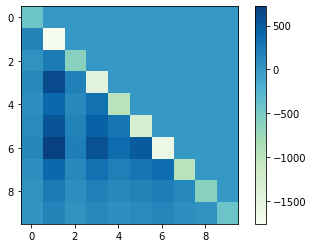

In [13]:
show_qubo(qubo)

In [30]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [31]:
from dwave.cloud import Client

In [34]:
# 接続情報をオプションとして渡す場合は以下のようにします。
solver = 'DW_2000Q_6'

In [35]:
dw = DWaveSampler(solver=solver)

In [37]:
sampler = EmbeddingComposite(dw)

In [73]:
response_test = sampler.sample_qubo(qubo_test, num_reads=100)

In [51]:
response = sampler.sample_ising(h, J, num_reads=100)

In [40]:
def calcurate_energy(solution, vartype='BINARY'):
    if vartype == 'BINARY':
        ene = sum(C) ** 2  # offset
        for i in range(N):
            ene += Q[i, i] * solution[i]
            for j in range(i + 1, N):
                ene += Q[i, j] * solution[i] * solution[j]
    elif vartype == 'SPIN':
        ene = sum(C[i] ** 2 for i in range(N))
        for i in range(N):
            for j in range(i + 1, N):
                ene += J[i, j] * solution[i] * solution[j]
    else:
        raise ValueError("vartype mast be 'BINARY' or 'SPIN'.")

    return ene

In [61]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
twenty_sol = []
for state in response.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='SPIN')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # 20 µsの結果を保存しておきます(あとで使用します)。
    twenty_sol.append(solution)

In [62]:
num_optimal_sol

16

In [79]:
response.info

{'timing': {'qpu_sampling_time': 23894.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 198.4,
  'qpu_access_time': 34719.1,
  'qpu_access_overhead_time': 1907.9,
  'qpu_programming_time': 10825.1,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 146.0,
  'total_post_processing_time': 146.0},
 'problem_id': '36c0c4a1-3173-4850-b151-f017ba392343'}

In [77]:
for solution in optimal_sol:
    group_A = [C[i] for i, s in enumerate(solution) if s==1]
    group_B = [C[i] for i, s in enumerate(solution) if s==-1]
    print(solution)
    print('Group A: ', group_A, ', Sum = ', sum(group_A))
    print('Group B: ', group_B, ', Sum = ', sum(group_B))

[1 1 0 1 0 0 0 1 0 1]
Group A:  [2, 10, 8, 5, 2] , Sum =  27
Group B:  [] , Sum =  0
[1 1 0 1 1 0 0 0 0 1]
Group A:  [2, 10, 8, 5, 2] , Sum =  27
Group B:  [] , Sum =  0
[0 0 0 1 1 0 1 0 1 1]
Group A:  [8, 5, 9, 3, 2] , Sum =  27
Group B:  [] , Sum =  0
[0 0 1 0 1 1 1 0 1 0]
Group A:  [3, 5, 7, 9, 3] , Sum =  27
Group B:  [] , Sum =  0
[1 1 0 0 1 0 0 1 1 1]
Group A:  [2, 10, 5, 5, 3, 2] , Sum =  27
Group B:  [] , Sum =  0
[0 1 0 0 0 1 0 1 1 1]
Group A:  [10, 7, 5, 3, 2] , Sum =  27
Group B:  [] , Sum =  0
[1 0 1 1 1 0 1 0 0 0]
Group A:  [2, 3, 8, 5, 9] , Sum =  27
Group B:  [] , Sum =  0
[1 0 1 1 1 0 1 0 0 0]
Group A:  [2, 3, 8, 5, 9] , Sum =  27
Group B:  [] , Sum =  0
[0 1 0 0 0 1 0 1 1 1]
Group A:  [10, 7, 5, 3, 2] , Sum =  27
Group B:  [] , Sum =  0
[0 1 0 0 0 1 0 1 1 1]
Group A:  [10, 7, 5, 3, 2] , Sum =  27
Group B:  [] , Sum =  0


In [78]:
response.data_vectors

{'energy': array([-270., -270., -370., -370., -370., -370., -370., -370., -370.,
        -370., -370., -370., -370., -366., -366., -366., -366., -366.,
        -366., -366., -366., -366., -366., -366., -366., -366., -174.,
        -174., -354., -354., -354., -354., -354., -354., -354., -354.,
        -354., -354., -354., -354., -354., -354., -354., -370., -354.,
        -334., -334., -334., -334., -334., -334., -334., -334., -334.,
        -334., -370., -354., -306., -306., -306., -306., -306., -306.,
        -270., -270., -270., -226., -226.]),
 'num_occurrences': array([ 6, 15,  1,  1,  2,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1,  1,  1,  2,
         1,  1,  1,  2,  1,  1,  3,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1]),
 'chain_break_fraction': array([0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. 

In [75]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
twenty_sol = []
for state in response_test.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='BINARY')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # 20 µsの結果を保存しておきます(あとで使用します)。
    twenty_sol.append(solution)

In [80]:
# イジングモデルの場合は以下を用います。
response = sampler.sample_ising(h, J, num_reads=100, annealing_time=50)

# QUBOの場合は以下を用います。
# response = sampler.sample_qubo(Q, num_reads=100, annealing_time=50)

In [81]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
fifty_sol = []
for state in response.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='SPIN')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # 50µsでの実行結果を保存します。
    fifty_sol.append(solution)

In [84]:
num_optimal_sol

6

# QUBOライブラリを使ってみる

In [14]:
from pyqubo import Array, Constraint, solve_qubo

In [67]:
x = Array.create('x', shape=(N), vartype='BINARY')

In [69]:
Q_test = sum(x)

In [70]:
model_test = Q_test.compile()
qubo_test, offset = model.to_qubo()

In [23]:
show_qubo(qubo)

TypeError: can only concatenate str (not "int") to str

In [21]:
qubo

{('x[2]', 'x[2]'): 2.0,
 ('x[9]', 'x[9]'): 2.0,
 ('x[8]', 'x[8]'): 2.0,
 ('x[7]', 'x[7]'): 2.0,
 ('x[3]', 'x[3]'): 2.0,
 ('x[6]', 'x[6]'): 2.0,
 ('x[5]', 'x[5]'): 2.0,
 ('x[4]', 'x[4]'): 2.0,
 ('x[0]', 'x[0]'): 2.0,
 ('x[1]', 'x[1]'): 2.0}

In [19]:
Q_test.compile()

Model(CompiledQubo(PlMonoPoly(2.000000*CoeffProd())*Prod(1)+PlMonoPoly(-10.000000*CoeffProd())*Prod()+PlMonoPoly(2.000000*CoeffProd())*Prod(2)+PlMonoPoly(2.000000*CoeffProd())*Prod(3)+PlMonoPoly(2.000000*CoeffProd())*Prod(4)+PlMonoPoly(2.000000*CoeffProd())*Prod(5)+PlMonoPoly(2.000000*CoeffProd())*Prod(6)+PlMonoPoly(2.000000*CoeffProd())*Prod(7)+PlMonoPoly(2.000000*CoeffProd())*Prod(8)+PlMonoPoly(2.000000*CoeffProd())*Prod(9)+PlMonoPoly(2.000000*CoeffProd())*Prod(10)), SubHs=[])

In [ ]:
# 第一項 (制約項)を定義します。
H_A = Constraint(sum((1-sum(x[v,i] for i in range(1,N_COLOR)))**2 for v in range(N_VER)), label='HA')
# 第二項 (コスト、目的関数)を定義します。
H_B = sum((-1+sum(x[v,i] for v in range (N_VER)))/2*(sum(x[v,i] for v in range (N_VER))) - sum(x[u,i]*x[v,i] for (u,v) in graph) for i in range (1,N_COLOR))
# ハミルトニアン全体を定義します。
Q = H_A+H_B